### Image Classification - Number vs Nonumber (Part 2)

> In lesson1 v2 of fast.ai, we learned "cats vs dogs" image classification.  The probability of the image being a cat or a dog.  In this notebook, I set to replicate lesson1 and create an image classifier that recognizes pictures with or without number(s).   The sample datasets are collected from "Street View Home Number" and "Cifar10" datasets.<br><br>
> I performed quick interaction in Part 1 with a smaller sample size to see if the basic classification works and if there is any code to debug.  After ensuring that classification works in general, in Part 2, I will use the entire SVHN datasets to train, validate and test.<br>

***Steps learned from lesson1***
1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from shutil import copyfile, move
import cv2
import glob

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
# Functions used to plot images:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))



In [6]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [7]:
# Source: https://gist.github.com/surmenok/8de6fd87af5f3dfe72e84ccaf690167e
def plot_loss_change(sched, sma=1, n_skip=20, y_lim=(-0.01,0.01)):
    """
    Plots rate of change of the loss function.
    Parameters:
        sched - learning rate scheduler, an instance of LR_Finder class.
        sma - number of batches for simple moving average to smooth out the curve.
        n_skip - number of batches to skip on the left.
        y_lim - limits for the y axis.
    """
    derivatives = [0] * (sma + 1)
    for i in range(1 + sma, len(learn.sched.lrs)):
        derivative = (learn.sched.losses[i] - learn.sched.losses[i - sma]) / sma
        derivatives.append(derivative)
        
    plt.ylabel("d/loss")
    plt.xlabel("learning rate (log scale)")
    plt.plot(learn.sched.lrs[n_skip:], derivatives[n_skip:])
    plt.xscale('log')
    plt.ylim(y_lim)

In [8]:
# Create "number" datasets paths. 
PATH = 'data/numbers/'

In [9]:
os.listdir(f'{PATH}') 

['models', 'train', 'valid', 'tmp', 'test']

In [10]:
os.listdir(f'{PATH}/train')

['nonumber', 'number']

In [11]:
test = os.listdir(f'{PATH}/test')
print(test[0:10]),
print(len(test))

['12031.png', '8927.png', '8585.png', '7587.png', '9593.png', '3072.png', '11077.png', '7076.png', '6062.png', '6124.png']
13069


In [12]:
t_nu = os.listdir(f'{PATH}/train/number')
print(t_nu[0:10]),
print(len(t_nu))

['number001656.png', 'number021396.png', 'number018497.png', 'number033298.png', 'number005684.png', 'number011562.png', 'number012166.png', 'number012873.png', 'number019980.png', 'number032599.png']
26722


In [13]:
t_no = os.listdir(f'{PATH}/train/nonumber')
print(t_no[0:10]),
print(len(t_no))

['nonumber007226.png', 'nonumber031356.png', 'nonumber019869.png', 'nonumber001642.png', 'nonumber014912.png', 'nonumber001864.png', 'nonumber031487.png', 'nonumber027173.png', 'nonumber008926.png', 'nonumber027711.png']
26719


In [14]:
v_nu = os.listdir(f'{PATH}/valid/number')
print(v_nu[0:10])
print(len(v_nu))

['number001656.png', 'number005684.png', 'number004342.png', 'number004011.png', 'number003399.png', 'number001971.png', 'number006072.png', 'number000398.png', 'number006590.png', 'number000773.png']
6680


In [15]:
v_no = os.listdir(f'{PATH}/valid/nonumber')
print(v_no[0:10])
print(len(v_no))

['nonumber001642.png', 'nonumber001864.png', 'nonumber001879.png', 'nonumber000533.png', 'nonumber004763.png', 'nonumber000472.png', 'nonumber001784.png', 'nonumber005149.png', 'nonumber005067.png', 'nonumber004997.png']
6680


In [16]:
# Print specific file type, file q'ty in a folder, and file names. 
def folder_inf(folder, formato):
    file_names = []
    for i in folder.rglob(formato):
        s = i.name
        file_names.append(s)
    print('Total number of images(type {}) in folder "{}" is "{}".'.format(formato, folder,
                                                                           len(file_names)))
    return(file_names)

# Shuffle files randomly within a folder.
def shuf_folder(folder, formato):
    shuf = []
    for i in folder.glob(formato):
        s = i.name
        shuf.append(s)
    random.shuffle(shuf)
    return(shuf)

# Copy from source to target folder
def copy_f1tof2(tocopy, source, target):
    for i in range(len(tocopy)):
        copyfile(str(source/tocopy[i]), str(target/tocopy[i]))

In [17]:
# Function to change the name of the files.
def change_f_names(path, name, formato):
    files = sorted(os.listdir(path))
    for idx, file in enumerate(files):
        new_name = (f'{name}{idx:06}{formato}')
        os.rename(os.path.join(path, file), \
              os.path.join(path, new_name))

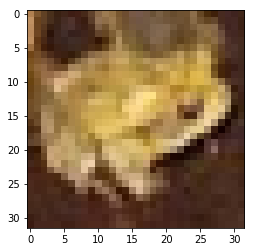

In [18]:
# Images from "train/nonumber" folder:
files = os.listdir(f'{PATH}/train/nonumber/')[:30]
img = plt.imread(f'{PATH}/train/nonumber/{files[5]}')
plt.imshow(img)


#### **Initial Setting**:
Follow settings from first part of lesson1<br>
1) arch = Resnet34(pretrained Imagenet)<br>
2) sz = 32<br>
3) bs = 64(default)<br>
4) lr = 0.01 <br>
5) epoch = 2 <br>
6) precompute = True<br>
7) data augmentation = False<br> 
8) images in folders:<br>
"train/nonumber" = 100 (Cifar10) <br>
"train/number" = 100 (SVHN)<br>
"valid/nonumber" = 20 (Cifar10)<br>
"valid/number" = 20 (SVHN)<br>
9) label naming: ex. "xxxx_ship.png" for nonumber; "xxxx.png" for number. 

In [19]:
arch = resnet34
sz = 32

data = ImageClassifierData.from_paths(PATH, bs = 128, tfms = tfms_from_model(arch, sz)) 
learn = ConvLearner.pretrained(arch, data, precompute = True)
learn.fit(0.01, 2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.048918   0.033171   0.989296  
    1      0.046145   0.030234   0.989596                     



[array([0.03023]), 0.9895958083832336]

High accuracy at first trial, but underfitting.

In [20]:
learn.lr_find()

A Jupyter Widget

 83%|████████▎ | 347/418 [00:04<00:00, 81.68it/s, loss=0.155] 


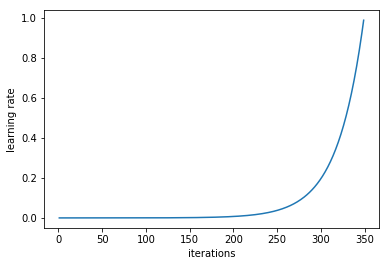

In [21]:
learn.sched.plot_lr()

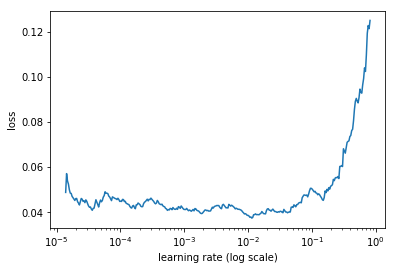

In [22]:
learn.sched.plot() # Printing graph, but quite strange curve!!

In [23]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [24]:
data.classes

['nonumber', 'number']

In [25]:
# Validation datasets, 20 images from nonumber and 20 from number.
log_preds = learn.predict()
log_preds.shape

(13360, 2)

In [26]:
log_preds[:10]

array([[ -0.00009,  -9.27296],
       [ -0.00006,  -9.65764],
       [ -0.04498,  -3.12401],
       [ -0.00017,  -8.65493],
       [ -0.00647,  -5.04434],
       [ -0.00802,  -4.83038],
       [ -0.00001, -11.21046],
       [ -0.00111,  -6.80184],
       [ -0.00005,  -9.93565],
       [ -0.00606,  -5.10878]], dtype=float32)

In [27]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1]) # pr that it is a number    

Correctly classified


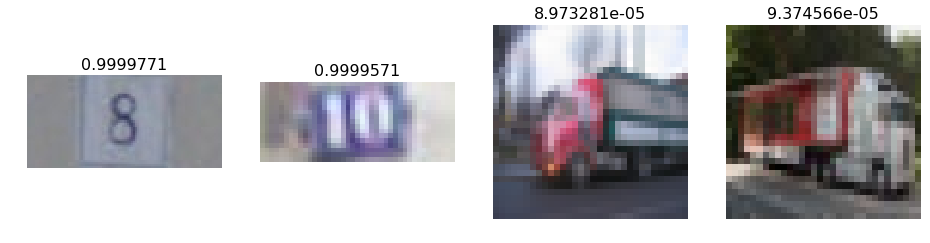

In [28]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


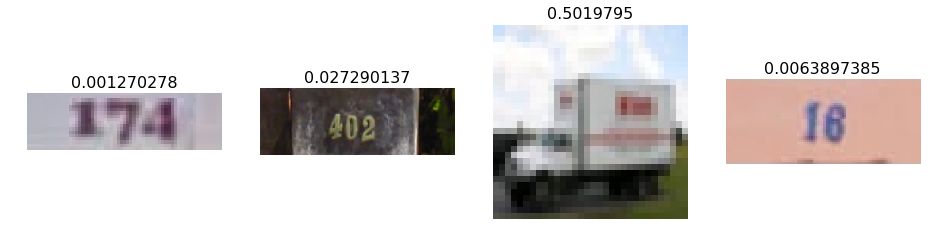

In [29]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct nonumber


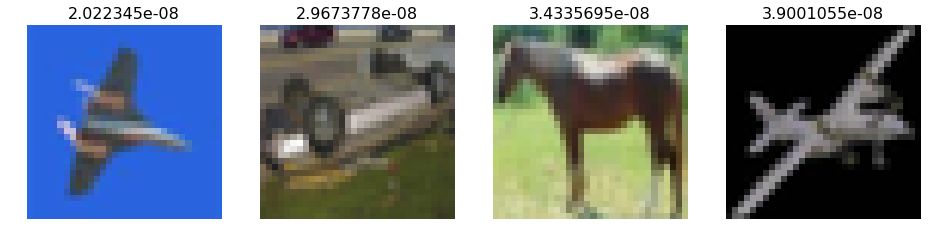

In [30]:
plot_val_with_title(most_by_correct(0, True), "Most correct nonumber")

Most correct number


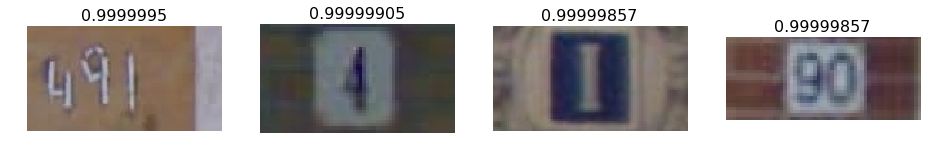

In [31]:
plot_val_with_title(most_by_correct(1, True), "Most correct number")

Most incorrect nonumber


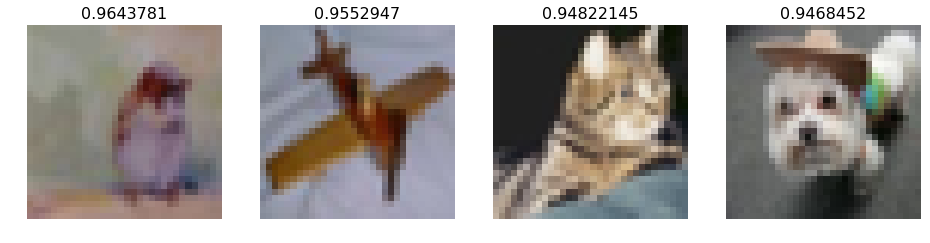

In [32]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect nonumber")

Most incorrect number


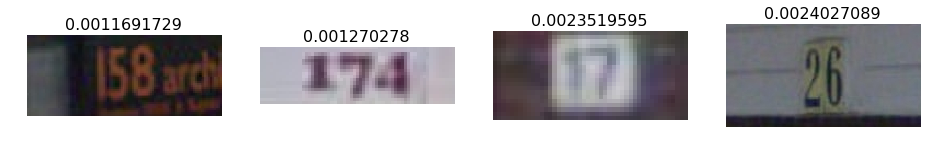

In [33]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect number")

Most uncertain predictions


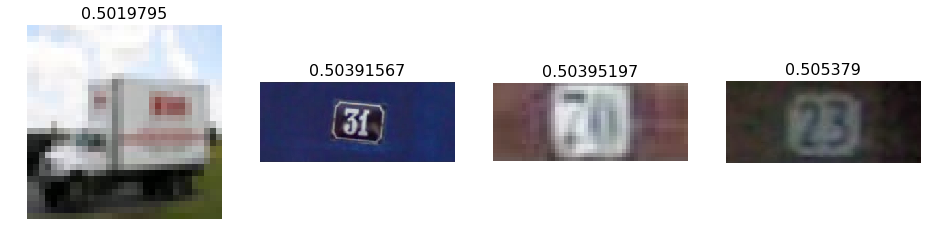

In [34]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

### End